We want payoff function 
$$payoff = \max\{x_1 - x_2 -\kappa, 0\}

# Distribution

In [2]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3
num_qubits_for_each_dimension = num_uncertainty_qubits + 1

# parameters for considered random distribution
S = 0.5  # initial spot price
vol = 0.5  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)


# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = 0
high = mean + 3 * stddev

print("mu: {}".format(mu))
print("sigma: {}".format(sigma))
print("mean: {}".format(mean))
print("stddev: {}".format(stddev))

print("lower bound: {}".format(low))
print("upper bound: {}".format(high))


# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix


# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

mu: -0.702462249053096
sigma: 0.1655211777204736
mean: 0.5021965917521902
stddev: 0.08369677802655558
lower bound: 0
upper bound: 0.753286925831857


In [2]:
strike_prices = np.array([0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2])
diff_values=  np.array([value[0] - value[1] for value in u.values])
print(u.values)
prob_of_happening = []
for strike_price in strike_prices:
    prob_of_happening.append(np.sum(u.probabilities[diff_values >= strike_price]))
    
prob_of_happening = np.array(prob_of_happening)
print(prob_of_happening)

[(0.0, 0.0), (0.0, 0.10761241797597956), (0.0, 0.21522483595195913), (0.0, 0.3228372539279387), (0.0, 0.43044967190391825), (0.0, 0.5380620898798978), (0.0, 0.6456745078558774), (0.0, 0.753286925831857), (0.10761241797597956, 0.0), (0.10761241797597956, 0.10761241797597956), (0.10761241797597956, 0.21522483595195913), (0.10761241797597956, 0.3228372539279387), (0.10761241797597956, 0.43044967190391825), (0.10761241797597956, 0.5380620898798978), (0.10761241797597956, 0.6456745078558774), (0.10761241797597956, 0.753286925831857), (0.21522483595195913, 0.0), (0.21522483595195913, 0.10761241797597956), (0.21522483595195913, 0.21522483595195913), (0.21522483595195913, 0.3228372539279387), (0.21522483595195913, 0.43044967190391825), (0.21522483595195913, 0.5380620898798978), (0.21522483595195913, 0.6456745078558774), (0.21522483595195913, 0.753286925831857), (0.3228372539279387, 0.0), (0.3228372539279387, 0.10761241797597956), (0.3228372539279387, 0.21522483595195913), (0.3228372539279387, 

In [3]:
u.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘

/tmp/ipykernel_1898895/4003109979.py:12: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  job = execute(quantum_circuit, Aer.get_backend('aer_simulator'), shots=1000)
/tmp/ipykernel_1898895/4003109979.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(quantum_circuit, Aer.get_backend('aer_simulator'), shots=1000)


{'111 111': 1, '100 111': 5, '111 110': 2, '011 100': 11, '011 111': 3, '101 011': 11, '100 101': 173, '101 110': 45, '011 110': 1, '101 101': 183, '110 101': 51, '110 100': 41, '100 100': 177, '110 110': 14, '111 101': 6, '101 111': 8, '110 011': 5, '011 101': 17, '101 100': 184, '100 011': 9, '111 100': 5, '100 110': 48}


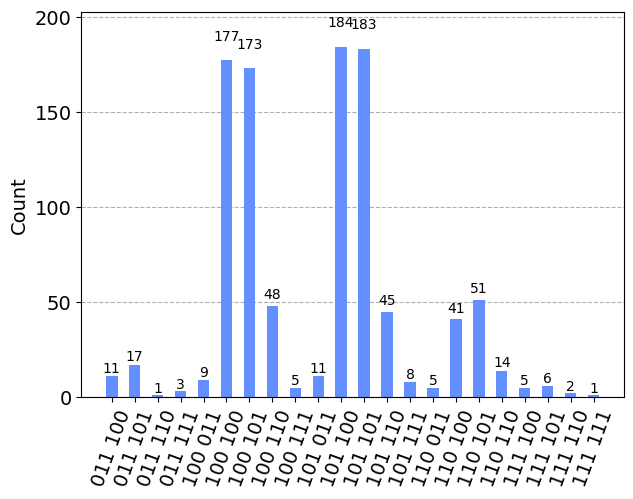

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
first_number_register = QuantumRegister(num_uncertainty_qubits, name='number1')
second_number_register = QuantumRegister(num_uncertainty_qubits, name='number2')
first_number_results = ClassicalRegister(num_uncertainty_qubits, name='classical1')
second_number_results = ClassicalRegister(num_uncertainty_qubits, name='classical2')

quantum_circuit = QuantumCircuit(first_number_register, second_number_register, first_number_results, second_number_results)
quantum_circuit.append(u, first_number_register[:] + second_number_register[:])
quantum_circuit.measure(first_number_register, first_number_results)
quantum_circuit.measure(second_number_register, second_number_results)

job = execute(quantum_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

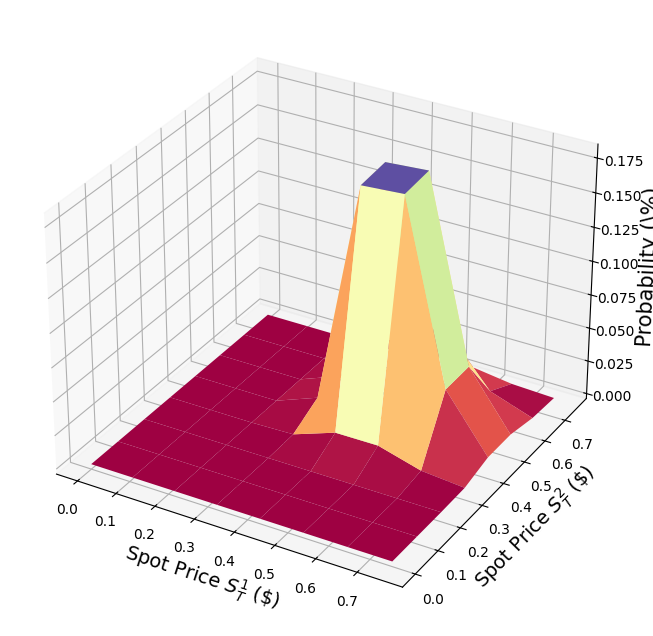

In [5]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit.library import VBERippleCarryAdder

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = QuantumRegister(num_qubits_for_each_dimension, 'ancilla')

adder = VBERippleCarryAdder(num_qubits_for_each_dimension, name="Adder")
# adder = DraperQFTAdder(num_qubits_for_each_dimension, kind="half",name="Adder")
num_qubits = len(adder.qubits)
print(num_qubits)

circ = QuantumCircuit(carryRegister, firstRegister, secondRegister, ancillaRegister, name="subtractor")
circ.x(secondRegister)
circ.x(carryRegister)
circ.append(adder, list(range(num_qubits)))
circ.draw()



13


┌───┐┌─────────┐
    carry: ┤ X ├┤0        ├
           └───┘│         │
  first_0: ─────┤1        ├
                │         │
  first_1: ─────┤2        ├
                │         │
  first_2: ─────┤3        ├
                │         │
  first_3: ─────┤4        ├
           ┌───┐│         │
 second_0: ┤ X ├┤5        ├
           ├───┤│         │
 second_1: ┤ X ├┤6  Adder ├
           ├───┤│         │
 second_2: ┤ X ├┤7        ├
           ├───┤│         │
 second_3: ┤ X ├┤8        ├
           └───┘│         │
ancilla_0: ─────┤9        ├
                │         │
ancilla_1: ─────┤10       ├
                │         │
ancilla_2: ─────┤11       ├
                │         │
ancilla_3: ─────┤12       ├
                └─────────┘

In [7]:
from qiskit.circuit.library import LinearAmplitudeFunction

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 0.08

# # map strike price from [low, high] to {0, ..., 2^n-1}
# max_value = 2 ** (num_qubits_for_each_dimension) - 1
# low_ = low[0]
# high_ = high[0]

# print("original range: {}".format([low_, high_]))
# print("qubit value range: {}".format([1, max_value]))
# print("strike price: {}".format(strike_price))


# # def mapping_function(x):
# #     return (
# #         (x - low_)
# #         * (2**num_uncertainty_qubits - 1) / (high_ - low_)
# #         + 2**num_uncertainty_qubits
# #     )

# # def inverse_mapping_function(x):
# #     return (
# #         (x - 2**num_uncertainty_qubits)
# #         * (high_ - low_) / (2**num_uncertainty_qubits - 1)
# #         + low_
# #     )

# # mapped_strike_price = mapping_function(strike_price)
# # print("mapped strike price: {}".format(mapped_strike_price))
# # mapped_strike_price = 8.1969


# # print("mapped strike price: {}".format(mapped_strike_price))
# # set the approximation scaling for the payoff function
# c_approx = 0.125

# # setup piecewise linear objective fcuntion
# breakpoints = [1, mapped_strike_price]
# slopes = [0, 1]
# offsets = [0, 0]


# f_min = 0
# f_max = max_value - mapped_strike_price
# print("payoff function range: {}".format([0, f_max]))

# max_value = 2 ** (num_qubits_for_each_dimension) - 1
low_ = low[0]
high_ = high[0]

# print("original range: {}".format([low_, high_]))
# print("qubit value range: {}".format([1, max_value]))
# print("strike price: {}".format(strike_price))

step = high_/7
print(step)

# mapped_strike_price = mapping_function(strike_price)
# print("mapped strike price: {}".format(mapped_strike_price))
# mapped_strike_price = 8.1969


# print("mapped strike price: {}".format(mapped_strike_price))
# set the approximation scaling for the payoff function
c_approx = 0.05

# setup piecewise linear objective fcuntion
breakpoints = [-8 *step, strike_price]
slopes = [0, 1]
offsets = [0, 0]


f_min = 0
f_max = high_ - strike_price
# print("payoff function range: {}".format([0, f_max]))

print("domain: {}".format([-8 *step, high_]))

spread_objective = LinearAmplitudeFunction(
    num_qubits_for_each_dimension,
    slopes,
    offsets,
    domain=(-8 *step, high_),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

print("\nnum qubits: ", spread_objective.num_qubits)
print("num ancillas: ", spread_objective.num_ancillas)

0.10761241797597956
domain: [-0.8608993438078365, 0.753286925831857]

num qubits:  9
num ancillas:  4


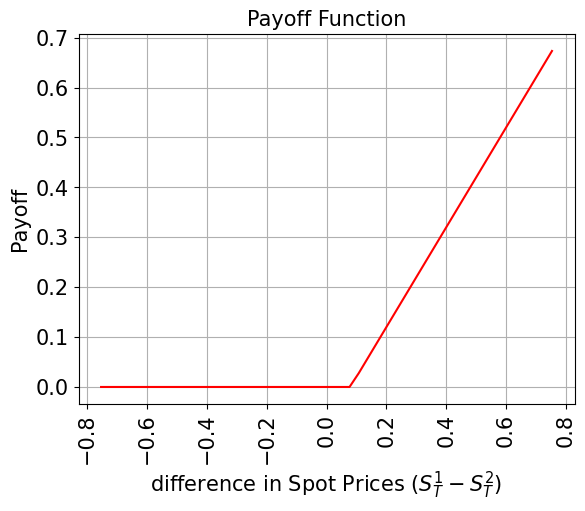

In [8]:
import matplotlib.pyplot as plt
x = np.linspace(low[0]-high[0], high[0])
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("difference in Spot Prices ($S_T^1 - S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [9]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit, ClassicalRegister
# define overall multivariate problem

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = AncillaRegister(max(num_qubits_for_each_dimension, spread_objective.num_ancillas), 'ancilla')
# first_number_register = ClassicalRegister(num_qubits_for_each_dimension, 'first_number')
second_number_register = ClassicalRegister(num_qubits_for_each_dimension, 'second_number')
# optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')
def swap_all(n):
    """Creates a circuit that swaps all qubits"""
    circuit = QuantumCircuit(n, name='SWAP_ALL')
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    return circuit


spread_option = QuantumCircuit(carryRegister, firstRegister, secondRegister, ancillaRegister, objectiveRegister, second_number_register)
spread_option.append(u, firstRegister[:-1] + secondRegister[:-1])
spread_option.append(circ, carryRegister[:] + firstRegister[:]+ secondRegister[:] + ancillaRegister[:])
# spread_option.measure(firstRegister, first_number_register)
spread_option.x(secondRegister[-1])
spread_option.measure(secondRegister, second_number_register)
spread_option.draw()


┌──────────────┐                 
          carry: ─────────┤0             ├─────────────────
                 ┌───────┐│              │                 
        first_0: ┤0      ├┤1             ├─────────────────
                 │       ││              │                 
        first_1: ┤1      ├┤2             ├─────────────────
                 │       ││              │                 
        first_2: ┤2      ├┤3             ├─────────────────
                 │       ││              │                 
        first_3: ┤  P(X) ├┤4             ├─────────────────
                 │       ││              │     ┌─┐         
       second_0: ┤3      ├┤5             ├─────┤M├─────────
                 │       ││              │     └╥┘┌─┐      
       second_1: ┤4      ├┤6  subtractor ├──────╫─┤M├──────
                 │       ││              │      ║ └╥┘┌─┐   
       second_2: ┤5      ├┤7             ├──────╫──╫─┤M├───
                 └───────┘│              │┌───┐ ║  ║ └╥┘┌─┐
       second_3: ─────────┤8             ├┤ X ├─╫──╫──╫─┤M├
                          │              │└───┘ ║  ║  ║ └╥┘
      ancilla_0: ─────────┤9             ├──────╫──╫──╫──╫─
                          │              │      ║  ║  ║  ║ 
      ancilla_1: ─────────┤10            ├──────╫──╫──╫──╫─
                          │              │      ║  ║  ║  ║ 
      ancilla_2: ─────────┤11            ├──────╫──╫──╫──╫─
                          │              │      ║  ║  ║  ║ 
      ancilla_3: ─────────┤12            ├──────╫──╫──╫──╫─
                          └──────────────┘      ║  ║  ║  ║ 
            obj: ───────────────────────────────╫──╫──╫──╫─
                                                ║  ║  ║  ║ 
second_number: 4/═══════════════════════════════╩══╩══╩══╩═
                                                0  1  2  3

/tmp/ipykernel_1878636/3006955977.py:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)


{'0100': 7, '0101': 89, '1011': 91, '0111': 2391, '1010': 637, '0110': 681, '1100': 5, '1001': 2383, '1000': 3716}


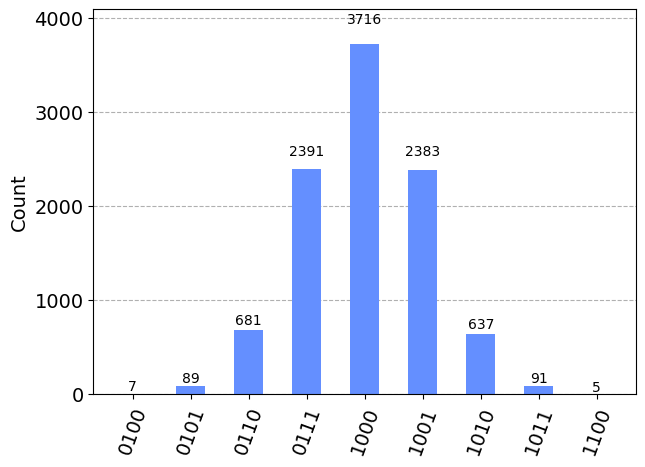

In [10]:
total_shots = 10000

job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)
counts = job.result().get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [11]:
diff_counts = {}
for bit_string, count in counts.items():
    decimal = int(bit_string, 2)
    if decimal > 2**(num_qubits_for_each_dimension-1):
        diff_counts[decimal-2**(num_uncertainty_qubits)] = count/total_shots

print(diff_counts)

single_unit = (high[0]-low[0])/(2**num_qubits_for_each_dimension-1)
print(single_unit)

total_earn = 0

for diff, prob in diff_counts.items():
    total_earn += prob * (single_unit * diff)

print(total_earn)
    

{3: 0.0091, 2: 0.0637, 4: 0.0005, 1: 0.2383}
0.05021912838879047
0.019836555713572235


In [12]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
# define overall multivariate problem

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = AncillaRegister(max(num_qubits_for_each_dimension, spread_objective.num_ancillas), 'ancilla')
optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')

def swap_all(n):
    """Creates a circuit that swaps all qubits"""
    circuit = QuantumCircuit(n, name='SWAP_ALL')
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    return circuit


spread_option = QuantumCircuit(carryRegister, firstRegister, secondRegister,objectiveRegister, ancillaRegister,  optionAncillaRegister)
spread_option.append(u, firstRegister[:-1] + secondRegister[:-1])
spread_option.append(circ, carryRegister[:] + firstRegister[:]+ secondRegister[:] + ancillaRegister[:])
spread_option.x(secondRegister[-1])
# swap = swap_all(num_qubits_for_each_dimension)
# spread_option.append(swap, secondRegister[:])
spread_option.append(spread_objective, secondRegister[:] + objectiveRegister[:] + optionAncillaRegister[:])

objective_index = num_qubits_for_each_dimension
spread_option.draw()


┌──────────────┐           
          carry: ─────────┤0             ├───────────
                 ┌───────┐│              │           
        first_0: ┤0      ├┤1             ├───────────
                 │       ││              │           
        first_1: ┤1      ├┤2             ├───────────
                 │       ││              │           
        first_2: ┤2      ├┤3             ├───────────
                 │       ││              │           
        first_3: ┤  P(X) ├┤4             ├───────────
                 │       ││              │     ┌────┐
       second_0: ┤3      ├┤5             ├─────┤0   ├
                 │       ││              │     │    │
       second_1: ┤4      ├┤6             ├─────┤1   ├
                 │       ││   subtractor │     │    │
       second_2: ┤5      ├┤7             ├─────┤2   ├
                 └───────┘│              │┌───┐│    │
       second_3: ─────────┤8             ├┤ X ├┤3   ├
                          │              │└───┘│    │
            obj: ─────────┤              ├─────┤4   ├
                          │              │     │    │
      ancilla_0: ─────────┤9             ├─────┤    ├
                          │              │     │    │
      ancilla_1: ─────────┤10            ├─────┤  F ├
                          │              │     │    │
      ancilla_2: ─────────┤11            ├─────┤    ├
                          │              │     │    │
      ancilla_3: ─────────┤12            ├─────┤    ├
                          └──────────────┘     │    │
optionAncilla_0: ──────────────────────────────┤5   ├
                                               │    │
optionAncilla_1: ──────────────────────────────┤6   ├
                                               │    │
optionAncilla_2: ──────────────────────────────┤7   ├
                                               │    │
optionAncilla_3: ──────────────────────────────┤8   ├
                                               └────┘

In [5]:
# evaluate exact expected value
diff_values = np.array([v[0]-v[1] for v in u.values])

exact_value = np.dot(
    u.probabilities[diff_values >= strike_price],
    diff_values[diff_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.5f" % exact_value)

exact expected value:	0.00219


In [6]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.001
alpha = 0.005

problem = EstimationProblem(
    state_preparation=spread_option,
    objective_qubits=[9],
    post_processing=spread_objective.post_processing,
)
# construct amplitude estimation

# qi = QuantumInstance(backend=AerSimulator(), shots=200)
# ae = ModifiedIterativeAmplitudeEstimation(
#     epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
# result = ae.estimate(problem, shots=200)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100000})
)
result = ae.estimate(problem)

NameError: name 'spread_option' is not defined

In [ ]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.4627690137007506, 0.462858337538451),
    'confidence_interval_processed': (   0.017478770670213563,
                                         0.018244504216478535),
    'epsilon_estimated': 4.466191885021953e-05,
    'epsilon_estimated_processed': 0.0003828667731324859,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.45537180486278145, 0.4663547872008897],
                              [0.4627690137007506, 0.462858337538451]],
    'estimation': 0.4628136756196008,
    'estimation_processed': 0.017861637443346047,
    'num_oracle_queries': 6100000,
    'powers': [0, 0, 61],
    'ratios': [1.0, 123.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.11788773719080789, 0.11964114872349924],
                           [0.11906901505077636, 0.11908327086229298]]}


In [17]:
# conf_int = (
#     (np.array(result.confidence_interval_processed))
#     / (2**(num_qubits_for_each_dimension)-1)
#     * (high_ - low_)
# )

# estimated_value = inverse_mapping_function(result.estimation_processed)
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed)
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(result.confidence_interval_processed))

Exact value:        	0.0177
Estimated value:    	0.0179
Confidence interval:	[0.0175, 0.0182]


## Alternative formulation

In [2]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3
num_qubits_for_each_dimension = num_uncertainty_qubits + 1

# parameters for considered random distribution
S = 0.5  # initial spot price
vol = 0.5  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)



# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = 0
high = mean + 3 * stddev

print("mu: {}".format(mu))
print("sigma: {}".format(sigma))

print("lower bound: {}".format(low))
print("upper bound: {}".format(high))


# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix


# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

mu: -0.702462249053096
sigma: 0.1655211777204736
lower bound: 0
upper bound: 0.753286925831857


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit.library import VBERippleCarryAdder
from qiskit.circuit.library import DraperQFTAdder, MCXGate

def oneIncrement(num_qubits):
    compute_register = QuantumRegister(num_qubits, 'compute')
    circuit = QuantumCircuit(compute_register)
    circuit.x(compute_register[0])
    circuit.cx(compute_register[0], compute_register[1], ctrl_state=0)
    for i in range(2, num_qubits):
        mcxGate = MCXGate(num_ctrl_qubits=i, ctrl_state="0"*i)
        circuit.append(mcxGate, compute_register[:i+1])
    return circuit

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
carryRegister = QuantumRegister(1, 'carry')
# ancillaRegister = QuantumRegister(num_qubits_for_each_dimension, 'ancilla')

# adder = VBERippleCarryAdder(num_qubits_for_each_dimension, name="Adder")
adder = DraperQFTAdder(num_qubits_for_each_dimension, kind="half",name="Adder")
num_qubits = len(adder.qubits)
print(num_qubits)

circ = QuantumCircuit(firstRegister, secondRegister, carryRegister, name="subtractor")
circ.x(secondRegister[:]+[carryRegister[0]])
# circ.x(carryRegister)
circ.append(adder, firstRegister[:] + secondRegister[:] + [carryRegister[0]])
circ.draw()

9


┌────────┐
 first_0: ─────┤0       ├
               │        │
 first_1: ─────┤1       ├
               │        │
 first_2: ─────┤2       ├
               │        │
 first_3: ─────┤3       ├
          ┌───┐│        │
second_0: ┤ X ├┤4 Adder ├
          ├───┤│        │
second_1: ┤ X ├┤5       ├
          ├───┤│        │
second_2: ┤ X ├┤6       ├
          ├───┤│        │
second_3: ┤ X ├┤7       ├
          ├───┤│        │
   carry: ┤ X ├┤8       ├
          └───┘└────────┘

In [4]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit, ClassicalRegister
# define overall multivariate problem

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
# first_number_register = ClassicalRegister(num_qubits_for_each_dimension, 'first_number')
second_number_register = ClassicalRegister(num_qubits_for_each_dimension, 'second_number')
# optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')

oneIncrementer = oneIncrement(num_qubits_for_each_dimension)
spread_option = QuantumCircuit(firstRegister, secondRegister, second_number_register, carryRegister, objectiveRegister)
spread_option.append(u, firstRegister[:-1] + secondRegister[:-1])
spread_option.append(circ, firstRegister[:]+ secondRegister[:]+ carryRegister[:])
spread_option.append(oneIncrementer, secondRegister[:])
# spread_option.measure(firstRegister, first_number_register)
spread_option.x(secondRegister[-1])

spread_option.measure(secondRegister, second_number_register)
spread_option.draw()

┌───────┐┌─────────────┐                                 
        first_0: ┤0      ├┤0            ├─────────────────────────────────
                 │       ││             │                                 
        first_1: ┤1      ├┤1            ├─────────────────────────────────
                 │       ││             │                                 
        first_2: ┤2      ├┤2            ├─────────────────────────────────
                 │       ││             │                                 
        first_3: ┤  P(X) ├┤3            ├─────────────────────────────────
                 │       ││             │┌──────────────┐     ┌─┐         
       second_0: ┤3      ├┤4 subtractor ├┤0             ├─────┤M├─────────
                 │       ││             ││              │     └╥┘┌─┐      
       second_1: ┤4      ├┤5            ├┤1             ├──────╫─┤M├──────
                 │       ││             ││  circuit-536 │      ║ └╥┘┌─┐   
       second_2: ┤5      ├┤6            ├┤2             ├──────╫──╫─┤M├───
                 └───────┘│             ││              │┌───┐ ║  ║ └╥┘┌─┐
       second_3: ─────────┤7            ├┤3             ├┤ X ├─╫──╫──╫─┤M├
                          │             │└──────────────┘└───┘ ║  ║  ║ └╥┘
          carry: ─────────┤8            ├──────────────────────╫──╫──╫──╫─
                          └─────────────┘                      ║  ║  ║  ║ 
            obj: ──────────────────────────────────────────────╫──╫──╫──╫─
                                                               ║  ║  ║  ║ 
second_number: 4/══════════════════════════════════════════════╩══╩══╩══╩═
                                                               0  1  2  3

/tmp/ipykernel_209919/4063562261.py:3: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)
/tmp/ipykernel_209919/4063562261.py:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)


{'0100': 36, '0101': 883, '1010': 6558, '0110': 6343, '1011': 962, '0111': 24068, '1100': 45, '1001': 24030, '1000': 37075}


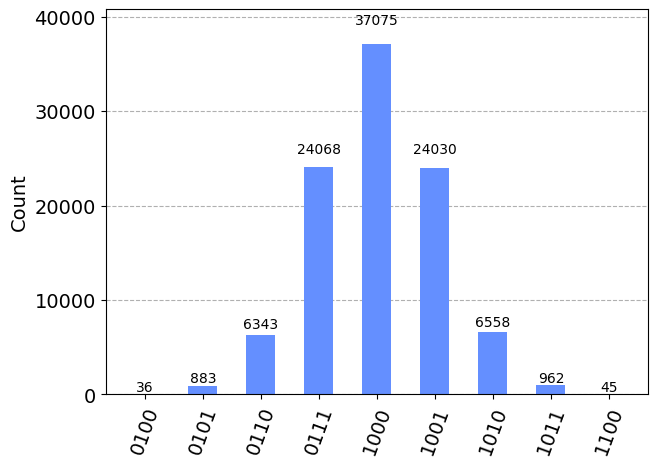

In [5]:
total_shots = 100000

job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)
counts = job.result().get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [6]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit, ClassicalRegister
# define overall multivariate problem



firstRegister = QuantumRegister(num_uncertainty_qubits, 'first')
secondRegister = QuantumRegister(num_uncertainty_qubits, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
second_number_register = ClassicalRegister(num_uncertainty_qubits+1, 'second_number')
# optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')

adder = DraperQFTAdder(num_uncertainty_qubits, kind="half",name="Adder")
circ = QuantumCircuit(firstRegister, secondRegister, carryRegister, name="subtractor")
circ.x(secondRegister[:]+[carryRegister[0]])
circ.append(adder, firstRegister[:] + secondRegister[:] + [carryRegister[0]])

oneIncrementer = oneIncrement(num_qubits_for_each_dimension)
spread_option = QuantumCircuit(firstRegister, secondRegister, second_number_register, carryRegister, objectiveRegister)
spread_option.append(u, firstRegister[:] + secondRegister[:])
spread_option.append(circ, firstRegister[:]+ secondRegister[:]+ carryRegister[:])
spread_option.append(oneIncrementer, secondRegister[:]+ carryRegister[:])
# spread_option.measure(firstRegister, first_number_register)
spread_option.x(carryRegister)

spread_option.measure(secondRegister[:]+carryRegister[:], second_number_register)
spread_option.draw()

┌───────┐┌─────────────┐                                 
        first_0: ┤0      ├┤0            ├─────────────────────────────────
                 │       ││             │                                 
        first_1: ┤1      ├┤1            ├─────────────────────────────────
                 │       ││             │                                 
        first_2: ┤2      ├┤2            ├─────────────────────────────────
                 │  P(X) ││             │┌──────────────┐     ┌─┐         
       second_0: ┤3      ├┤3 subtractor ├┤0             ├─────┤M├─────────
                 │       ││             ││              │     └╥┘┌─┐      
       second_1: ┤4      ├┤4            ├┤1             ├──────╫─┤M├──────
                 │       ││             ││  circuit-560 │      ║ └╥┘┌─┐   
       second_2: ┤5      ├┤5            ├┤2             ├──────╫──╫─┤M├───
                 └───────┘│             ││              │┌───┐ ║  ║ └╥┘┌─┐
          carry: ─────────┤6            ├┤3             ├┤ X ├─╫──╫──╫─┤M├
                          └─────────────┘└──────────────┘└───┘ ║  ║  ║ └╥┘
            obj: ──────────────────────────────────────────────╫──╫──╫──╫─
                                                               ║  ║  ║  ║ 
second_number: 4/══════════════════════════════════════════════╩══╩══╩══╩═
                                                               0  1  2  3

/tmp/ipykernel_209919/4063562261.py:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)


{'0100': 38, '0101': 890, '1011': 923, '0111': 23846, '1010': 6423, '0110': 6611, '1100': 29, '1000': 37132, '1001': 24108}


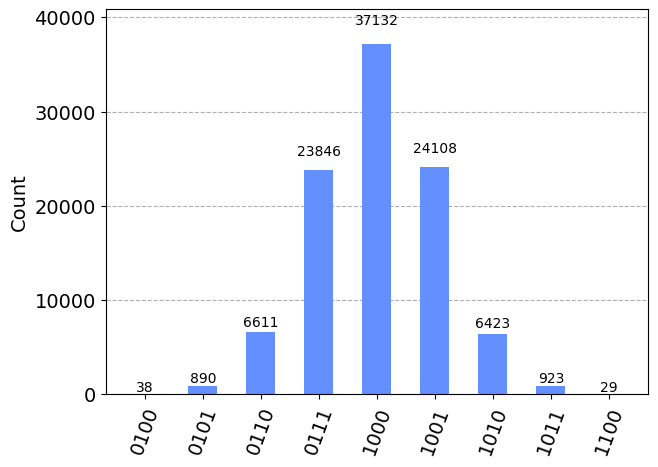

In [7]:
total_shots = 100000

job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=total_shots)
counts = job.result().get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [8]:
from qiskit.circuit.library import LinearAmplitudeFunction

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 0.07

low_ = low[0]
high_ = high[0]

# print("original range: {}".format([low_, high_]))
# print("qubit value range: {}".format([1, max_value]))
# print("strike price: {}".format(strike_price))

step = high_/(2**num_uncertainty_qubits-1)

c_approx = 0.05

# setup piecewise linear objective fcuntion
breakpoints = [-8 *step, strike_price]
slopes = [0, 1]
offsets = [0, 0]


f_min = 0
f_max = high_ - strike_price
# print("payoff function range: {}".format([0, f_max]))

spread_objective = LinearAmplitudeFunction(
    num_qubits_for_each_dimension,
    slopes,
    offsets,
    domain=(-2**num_uncertainty_qubits *step, high_),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

print("\nnum qubits: ", spread_objective.num_qubits)
print("num ancillas: ", spread_objective.num_ancillas)


num qubits:  9
num ancillas:  4


In [9]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
from package.helper import Subtractor
# define overall multivariate problem

firstRegister = QuantumRegister(num_uncertainty_qubits, 'first')
secondRegister = QuantumRegister(num_uncertainty_qubits, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')

spread_option = QuantumCircuit(firstRegister, secondRegister,carryRegister, objectiveRegister,  optionAncillaRegister)
spread_option.append(u, firstRegister[:] + secondRegister[:])
spread_option.append(circ, firstRegister[:]+ secondRegister[:]+ carryRegister[:])
spread_option.append(oneIncrementer, secondRegister[:]+ carryRegister[:])
# spread_option.measure(firstRegister, first_number_register)
spread_option.x(carryRegister)
spread_option.append(spread_objective, secondRegister[:] + carryRegister[:] + objectiveRegister[:] + optionAncillaRegister[:])

objective_index = num_qubits_for_each_dimension
print(objective_index)

spread_option.draw()

4


┌───────┐┌─────────────┐                           
        first_0: ┤0      ├┤0            ├───────────────────────────
                 │       ││             │                           
        first_1: ┤1      ├┤1            ├───────────────────────────
                 │       ││             │                           
        first_2: ┤2      ├┤2            ├───────────────────────────
                 │  P(X) ││             │┌──────────────┐     ┌────┐
       second_0: ┤3      ├┤3 subtractor ├┤0             ├─────┤0   ├
                 │       ││             ││              │     │    │
       second_1: ┤4      ├┤4            ├┤1             ├─────┤1   ├
                 │       ││             ││  circuit-560 │     │    │
       second_2: ┤5      ├┤5            ├┤2             ├─────┤2   ├
                 └───────┘│             ││              │┌───┐│    │
          carry: ─────────┤6            ├┤3             ├┤ X ├┤3   ├
                          └─────────────┘└──────────────┘└───┘│    │
            obj: ─────────────────────────────────────────────┤4 F ├
                                                              │    │
optionAncilla_0: ─────────────────────────────────────────────┤5   ├
                                                              │    │
optionAncilla_1: ─────────────────────────────────────────────┤6   ├
                                                              │    │
optionAncilla_2: ─────────────────────────────────────────────┤7   ├
                                                              │    │
optionAncilla_3: ─────────────────────────────────────────────┤8   ├
                                                              └────┘

In [10]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.001
alpha = 0.005

problem = EstimationProblem(
    state_preparation=spread_option,
    objective_qubits=[7],
    post_processing=spread_objective.post_processing,
)
# construct amplitude estimation

qi = QuantumInstance(backend=AerSimulator(), shots=200)
ae = ModifiedIterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem, shots=200)
# construct amplitude estimation
# ae = IterativeAmplitudeEstimation(
#     epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 10000})
# )
# result = ae.estimate(problem)

/tmp/ipykernel_209919/2850422585.py:19: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=AerSimulator(), shots=200)


In [11]:
# evaluate exact expected value
diff_values = np.array([v[0]-v[1] for v in u.values])

exact_value = np.dot(
    u.probabilities[diff_values >= strike_price],
    diff_values[diff_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.5f" % exact_value)

exact expected value:	0.02088


In [20]:
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed)
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(result.confidence_interval_processed))

Exact value:        	0.0209
Estimated value:    	0.0223
Confidence interval:	[0.0181, 0.0264]


In [21]:
import inspect

result_JSON = {}
for name, value in inspect.getmembers(result):
    if (
        not name.startswith("_")
        and not inspect.ismethod(value)
        and not inspect.isfunction(value)
        and hasattr(result, name)
    ):

        result_JSON[name] = value

In [22]:
print(result_JSON)

{'alpha': 0.005, 'circuit_results': None, 'confidence_interval': (0.462812997059045, 0.4637670055028406), 'confidence_interval_processed': (0.01812102417593584, 0.026420782529825302), 'epsilon_estimated': 0.0004770042218978088, 'epsilon_estimated_processed': 0.004149879176944732, 'epsilon_target': None, 'estimate_intervals': [[0.0, 1.0], [0.2804114559807015, 0.598855948087935], [0.42385945968923383, 0.5271252606654697], [0.44592164034646115, 0.47849628648180526], [0.45879260044757486, 0.46499992946242247], [0.462812997059045, 0.4637670055028406]], 'estimation': 0.4632900012809428, 'estimation_processed': 0.022270903352880327, 'num_oracle_queries': 60600, 'powers': [0, 1, 4, 21, 123, 123], 'ratios': [3.0, 3.0, 4.777777777777778, 5.744186046511628, 1.0], 'shots': None, 'theta_intervals': [[0, 1], [0.3552700672108502, 0.5633510485812652], [0.4513381014871019, 0.5172769590391352], [0.465505170027961, 0.4863060871151764], [0.4737367664087535, 0.4777000259947568], [0.4763041387365851, 0.4769

In [23]:
import json
with open('data.json', 'w') as f:
    json.dump(result_JSON, f)